In [2]:
import torch
import pandas as pd
import numpy as np
import json
import random
from datasets import Dataset, DatasetDict
from IPython.display import clear_output

import sys
sys.path.append("../")
from src.loss_plot import log_history_to_plot

In [3]:
SEED = 2024*5
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Загрузим подготовленные данные

In [4]:
from datasets import concatenate_datasets

In [5]:
train_dataset = Dataset.load_from_disk("../data_processed/train_dataset")
aug_dataset = Dataset.load_from_disk("../data_processed/aug_dataset")
test_dataset = Dataset.load_from_disk("../data_processed/test_dataset")

In [6]:
print(train_dataset[0])

{'id': 0, 'tokens': ['**Когда', 'квитанция', 'поступит,**', 'вАрхиве', 'поступлений', 'в', '«Статусе', 'маркировки»', 'отобразится', 'статус', 'по', 'накладной', '«Продажа', 'разрешена»', 'или', '«Принято', 'с', 'расхождениями».', '\n', '\nПринятые', 'марки', 'добавятся', 'на', 'остатки', 'магазина,', '**товары', 'станут', 'доступны', 'для', 'продажи', 'на', 'кассе**.\n*', '**Принято', 'с', 'расхождениями**', '–', 'марки', 'приняты', 'НЕ', 'ПО', 'ВСЕМ', 'товарам.', '\n', '\nНеобходимо', 'провалиться', 'в', 'документ', 'поступления', 'и', 'проверить', 'статус', 'маркировки', 'по', 'каждой', '+7', '010', '618', '1753', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 22, 22, 22, 0], 'ner_names': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

In [7]:
with open("../data_processed/id2labels.json", encoding="utf-8") as f:
    id2label = json.load(f)

    id2label = {int(k) : v for k, v in id2label.items()}

with open("../data_processed/labels2id.json", encoding="utf-8") as f:
    label2id = json.load(f)

label_list = list(label2id.keys())

In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base", add_prefix_space=True)

d:\Projects\Codenrock\maskirovanie-5629\.venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
dataset = DatasetDict()
dataset["train"] = concatenate_datasets([aug_dataset, train_dataset])
dataset["test"] = test_dataset

In [10]:
# Функция для выравнивания меток после токенизации
# Source: https://huggingface.co/learn/nlp-course/chapter7/2
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                # Специальные токены будут помечены как -100
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # Мы попали на первую часть текущего слова, сохраняем индекс метки
                label_ids.append(label[word_idx])
            elif word_idx == previous_word_idx:
                # Мы попали на продолжение текущего слова
                label_idx = label[word_idx]
                label_name = id2label[label_idx]

                if label_name[:2] == "B-":
                    # слово с меткой B- разделилось на 2 части, заменяем его метку на I-
                    # и меняем индекс метки
                    label_name = "I-" + label_name[2:]
                    label_idx = int(label2id[label_name])
                
                label_ids.append(label_idx)
            else:
                label_ids.append(-100)

            previous_word_idx = word_idx
            
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [11]:
tokenized_data = dataset.map(tokenize_and_align_labels, batched=True)

Map: 100%|██████████| 60/60 [00:00<00:00, 1843.10 examples/s]


In [12]:
tokenized_data["test"]

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'ner_names', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 60
})

In [13]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [14]:
# Функция для вычисления метрик в процессе обучения модели
# Source: https://huggingface.co/learn/nlp-course/chapter7/2

import evaluate
seqeval = evaluate.load("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# Загрузка модели:

In [80]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForTokenClassification.from_pretrained("ai-forever/ruBert-base", \
     num_labels=len(id2label.keys()), id2label=id2label, label2id=label2id).to(device)

# Заморозка эмбеддингов
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

# Заморозка весов у слоев энкодера
for layer in model.bert.encoder.layer[:2]:
    for param in layer.parameters():
        param.requires_grad = False

model.device

d:\Projects\Codenrock\maskirovanie-5629\.venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cuda', index=0)

# Обучение модели:

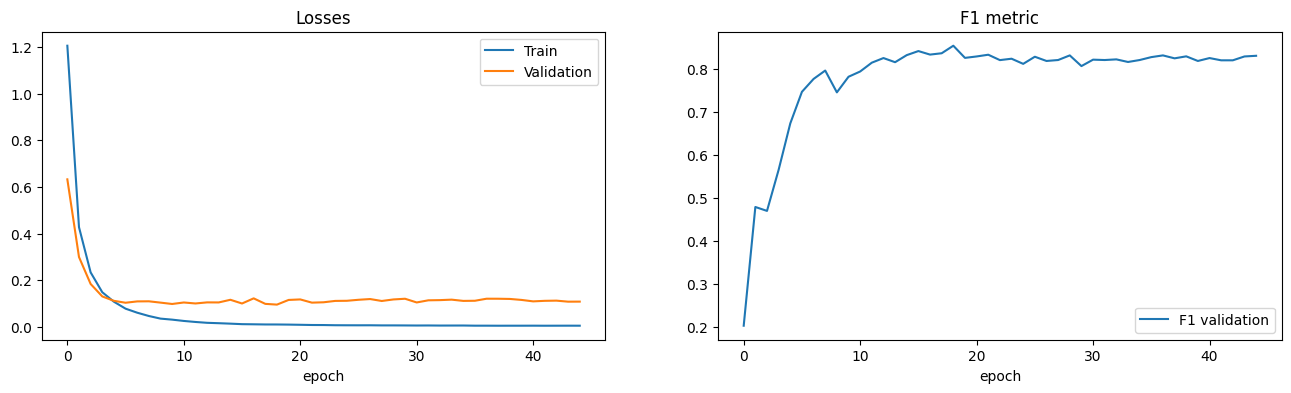

In [81]:
training_args = TrainingArguments(
    output_dir="../results/",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=45,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

clear_output(True)
log_history_to_plot(trainer.state.log_history)

# EVAL TEST

In [83]:
model = AutoModelForTokenClassification.from_pretrained("../results/checkpoint-646")
tokenizer = AutoTokenizer.from_pretrained("../results/checkpoint-646")

In [89]:
from transformers import pipeline

pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy='average')
results = pipe(" ".join(test_dataset["tokens"][1]))
print(results)

[{'entity_group': 'MAIL', 'score': 0.9642366, 'word': 'krasilnikovamos @ gruppa. edu', 'start': 212, 'end': 238}, {'entity_group': 'LINK', 'score': 0.99311686, 'word': 'http : / / rao. org /', 'start': 293, 'end': 308}]


In [85]:
trainer.model.to("cuda")
trainer.evaluate(tokenized_data["test"])

100%|██████████| 4/4 [00:00<00:00,  8.70it/s]


{'eval_loss': 0.09489590674638748,
 'eval_precision': 0.8321167883211679,
 'eval_recall': 0.8769230769230769,
 'eval_f1': 0.8539325842696629,
 'eval_accuracy': 0.9785746168724893,
 'eval_runtime': 0.9345,
 'eval_samples_per_second': 64.203,
 'eval_steps_per_second': 4.28,
 'epoch': 45.0}

In [ ]:
from ipymarkup import show_span_box_markup
# SHOW TEST PREDS

for item in test_dataset["tokens"]:
    text = " ".join(item)
    spans = []
    ner_results = pipe(text)
    for entity in ner_results:
         spans.append((entity["start"], entity["end"], entity["entity_group"]))

    show_span_box_markup(text, spans)